## Importing Dependencies

In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder

## Importing data and Preprocessing it for training

In [0]:
data=tf.keras.datasets.mnist
(trainX,trainY),(testX,testY)=data.load_data()
num_of_channels=1
trainX=trainX/255.0
testX=testX/255.0
shape_train=trainX.shape
shape_test=testX.shape
trainX=trainX.reshape([shape_train[0],shape_train[1],shape_train[2],num_of_channels])
testX=testX.reshape([shape_test[0],shape_test[1],shape_test[2],num_of_channels])
enc=OneHotEncoder(sparse=False)
trainY=enc.fit_transform(trainY.reshape(len(trainY),1))
testY=enc.fit_transform(testY.reshape(len(testY),1))
print("Shape of Data")
print("Training Data ",trainX.shape)
print("Test Data ",testX.shape)
batch_size=250
learning_rate=0.001
img_size=(28,28)
num_of_classes=10

Shape of Data
Training Data  (60000, 28, 28, 1)
Test Data  (10000, 28, 28, 1)


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a Lab

## Helper Functions to plot Images

In [0]:
def plot_images(images, cls_true, cls_pred=None,w=3,h=3):
    assert len(images) == len(cls_true)==w*h
    fig, axes = plt.subplots(w, h)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].reshape(img_size), cmap='binary')
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])
        ax.set_xlabel(xlabel)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

In [0]:
def plot_graph(data):
    plt.plot(data)
    plt.show()

## Checking some Images by plotting them with true labels

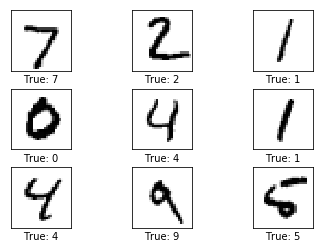

In [0]:
images=testX[0:9]
true_class=np.argmax(testY[0:9],axis=1)
plot_images(images,true_class)

## Functions to Create Weight and Biases baased on shape provided as parameter

In [0]:
def weights(shape):
    return tf.Variable(tf.truncated_normal(shape,stddev=0.1))

In [0]:
def bias(shape):
    return tf.Variable(tf.truncated_normal(shape,stddev=0.1))

## Function for making a Convolutional 2D Layer

In [0]:
def Conv(input,filter_size=2,num_of_filters=10,input_channel=3,padding="SAME",strides=[1,1,1,1],pooling=False,pool_size=[1,2,2,1],pool_strides=[1,1,1,1]):
    shape=[filter_size,filter_size,input_channel,num_of_filters]
    w=weights(shape)
    b=bias([shape[-1]])
    layer=tf.nn.conv2d(input,filter=w,strides=strides,padding=padding)
    layer+=b
    if pooling:
        layer=tf.nn.max_pool(layer,ksize=pool_size,strides=pool_strides,padding=padding)
    layer=tf.nn.relu(layer)
    return layer

## Function to flatten the output from Convolutional layer to be feed to Dense Layer of neural network

In [0]:
def Flatten(input):
    shape=input.shape
    features=1
    for i in shape[1:]:
        features*=i
    input=tf.reshape(input,[-1,features])
    return input

## Function to for making a neural network layer

In [0]:
def Dense(input,output_size):
    shape_weight=int(input.shape[-1])
    w=weights([shape_weight,output_size])
    b=bias([1,output_size])
    layer=tf.matmul(input,w)+b
    layer=tf.nn.relu(layer)
    return layer

## Defining placeholders and creating Layers

In [0]:
# Layer1
filters_1=16
#Layer2
filters_2=32
#Layer3 Flatten
#Layer3 Fully Connected Layer
x=tf.placeholder(tf.float32,[None,img_size[0],img_size[1],num_of_channels])
y=tf.placeholder(tf.float32,[None,num_of_classes])

In [0]:
conv_1=Conv(x, filter_size=3,num_of_filters=filters_1,input_channel=num_of_channels,pooling=True)

In [0]:
conv_2=Conv(conv_1,filter_size=5,num_of_filters=filters_2,input_channel=filters_1,pooling=True)

In [0]:
flat_layer=Flatten(conv_2)

## Getting Prediction from network to generate loss 

In [0]:
layer1=Dense(flat_layer,128)
y_pred=Dense(layer1,num_of_classes)
prediction=tf.nn.softmax(y_pred)

## Defining our loss Function and optimizer

In [0]:
cross_entropy=tf.nn.softmax_cross_entropy_with_logits_v2(labels=y,logits=y_pred)
loss=tf.reduce_mean(cross_entropy)/batch_size
accurate = tf.equal(tf.argmax(prediction,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(accurate, tf.float32))

In [0]:
optimizer=tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

## Creating and initializing tensorflow session

In [0]:
session=tf.Session()
session.run(tf.global_variables_initializer())

## Feed Dict for finding accuracy

In [0]:
feed_dict_test = {x: testX,y: testY}

## Function to print accuracy of model on test data

In [0]:
def print_accuracy():
    acc = session.run(accuracy, feed_dict=feed_dict_test)
    print("Accuracy on test-set: {0:.1%}".format(acc))

## Plotting Confusion Matrix for getting idea of accuracy

In [0]:
def print_confusion_matrix():
    prediction = session.run(y_pred, feed_dict=feed_dict_test)
    cls_true=np.argmax(prediction,axis=1)
    cm = confusion_matrix(y_true=np.argmax(testY,axis=1),y_pred=cls_true)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.tight_layout()
    plt.colorbar()
    tick_marks = np.arange(num_of_classes)
    plt.xticks(tick_marks, range(num_of_classes))
    plt.yticks(tick_marks, range(num_of_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

## Training Function

In [0]:
def train(iterations):
    cost=[]
    for i in range(iterations):
        rnd_index=np.random.choice(len(trainX),batch_size)
        x_batch=trainX[rnd_index]
        y_batch=trainY[rnd_index]
        train_dict={x:x_batch,y:y_batch}
        session.run(optimizer,feed_dict=train_dict)
        if i % 100 == 0:
            minibatch_loss, minibatch_accuracy = session.run([loss, accuracy],feed_dict={x: x_batch, y: y_batch})
            print("Iteration {0}  |   Loss = {1}  |   Accuracy = {2:.1%}".format(i,minibatch_loss,minibatch_accuracy))
            cost.append(minibatch_loss)
    return np.array(cost)

## Printing accuracy of network before training

In [0]:
print_accuracy()

Accuracy on test-set: 10.7%


## Training our ConvNet and plotting its loss

In [0]:
cost=train(1000)
plot_graph(cost)
print_accuracy()

Iteration 0  |   Loss = 0.010572749190032482  |   Accuracy = 10.4%
Iteration 100  |   Loss = 0.003917786758393049  |   Accuracy = 60.4%
Iteration 200  |   Loss = 0.003339366754516959  |   Accuracy = 66.4%
Iteration 300  |   Loss = 0.002995481248944998  |   Accuracy = 68.4%
Iteration 400  |   Loss = 0.0032795947045087814  |   Accuracy = 65.2%
Iteration 500  |   Loss = 0.003163429908454418  |   Accuracy = 66.4%
Iteration 600  |   Loss = 0.003261422272771597  |   Accuracy = 66.0%
Iteration 700  |   Loss = 0.003092658007517457  |   Accuracy = 66.8%
Iteration 800  |   Loss = 0.002935132710263133  |   Accuracy = 68.8%
Iteration 900  |   Loss = 0.0030780783854424953  |   Accuracy = 67.2%
Iteration 1000  |   Loss = 0.002765329321846366  |   Accuracy = 70.4%
Iteration 1100  |   Loss = 0.002985544502735138  |   Accuracy = 68.0%
Iteration 1200  |   Loss = 0.002993072150275111  |   Accuracy = 68.8%
Iteration 1300  |   Loss = 0.003306660335510969  |   Accuracy = 64.0%
Iteration 1400  |   Loss = 0.0

## Plotting Confusion matrix to get idea of model

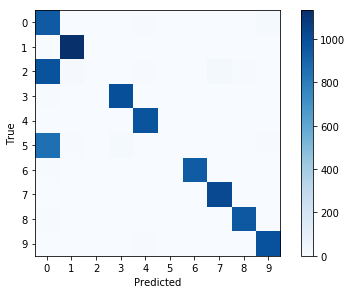

Accuracy on test-set: 79.8%


In [0]:
print_confusion_matrix()
print_accuracy()

## Closing session after use

In [0]:
session.close()